In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../lib/src/')
import torch
import numpy as np
from torch import nn
import os
from matplotlib import pyplot as plt
from itertools import islice
import lightning as L
import logging
from sklearn.decomposition import PCA

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0), cmap = 'gray')
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)

def extract_dataset(loader, only_last = False, c = 3, h = 28, w = 28):
    dataset = []

    for data, label in loader:
        data = data.squeeze(2,3) #(32, 18, 3, 28, 28)
        if only_last:
            data = data[:, -1]
        data = data.reshape(-1, c, h, w)
        dataset.append(data)
    
    dataset = torch.cat(dataset, 0)
    return dataset

%reload_ext autoreload
%autoreload 2

In [2]:

DATA_PATH = 'data-models/starmen/data/starmen_data.pt' #modify if needed

device = 'cpu'

train_data = torch.load(DATA_PATH)[:700, -1].unsqueeze(2).reshape(-1, 1, 64, 64)
eval_data = torch.load(DATA_PATH)[700:900, -1].unsqueeze(2).reshape(-1, 1, 64, 64)
print(train_data.shape)
print(eval_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([700, 1, 64, 64])
torch.Size([200, 1, 64, 64])


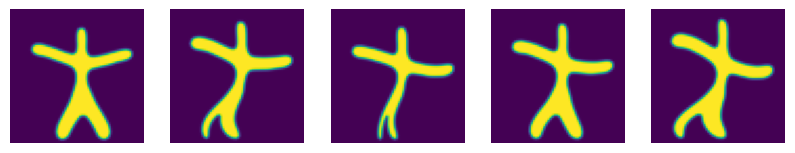

In [3]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [4]:
input_dim = (1, 28, 28)
f = 14 #subsampling factor
latent_dim = 3* (28 // f) * (28 // f)
print('Latent dim:', latent_dim)

# device = 'cuda'
# vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-08-01_16-38-44/final_model').to(device)
# vae.eval()


Latent dim: 12


VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
  

In [5]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


######## UNET #######
in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

h, w = 28//f, 28//f


z = torch.randn(1, 3, h, w)
print("Shape of input U-NET: ", z.shape)
empty_prompt_embed = None
print("Shape of output: ", unet(z, torch.tensor([10]), empty_prompt_embed).shape)
print("Number of trainable params: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.0012


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)

Shape of input U-NET:  torch.Size([1, 3, 2, 2])
Shape of output:  torch.Size([1, 3, 2, 2])
Number of trainable params:  2223043


In [ ]:
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 5*1e-6
BATCH_SIZE = 64
MAX_EPOCHS = 100

vae = vae.to('cuda')
latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
model = LitLDM(ldm = latent_diffusion, vae = vae, lr = lr).to('cuda')



train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, train_loader, val_loader)

#model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

In [ ]:
vae = vae.to('cuda')
model = model.to('cuda')
trainer = L.Trainer()
trainer.validate(model, val_loader)
trainer.validate(model, train_loader)